In [ ]:
import requests
import zipfile
import os
from google.colab import drive
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import re
import numpy as np

In [ ]:
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', 200)         # adjust based on terminal width
pd.set_option('display.float_format', '{:.5f}'.format)  # float precision
pd.set_option("display.precision", 5)



In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Load the dataset (Excel file)
file_path = '/content/gdrive/My Drive/xtdata.csv'
xT = pd.read_csv(file_path)

Mounted at /content/gdrive


In [ ]:
file_path = '/content/gdrive/My Drive/Riskv13.csv'
risk = pd.read_csv(file_path)

In [ ]:
file_path = '/content/gdrive/My Drive/xtdatasucc.csv'
succ = pd.read_csv(file_path)

In [ ]:
xt = xT[["original_event_id","team_name", "xT", "xT_unsucc", "start_x", "start_y", 'end_x', 'end_y']]

In [ ]:
# Perform the left join on 'original_event_id'
merged_df = pd.merge(
    risk,
    xt,
    on='original_event_id',
    how='left'
)


In [ ]:
merged_df = pd.merge(
    merged_df,
    succ[['original_event_id', 'xT_succ']],
    on='original_event_id',
    how='left'
)

In [ ]:
len(merged_df)

29383

In [ ]:
# Select the desired columns
ready_df = merged_df[[
    'game_id',
    'original_event_id',
    'team_name',
    'player_id',
    'player_name',
    'starting_position',
    'result_id',
    'predicted_class',
    'predicted_prob',
    'xT',
    'xT_unsucc',
    'xT_succ',
    'start_x',
    'start_y',
    'end_x',
    'end_y'
]].copy()

In [ ]:
# Count passes with negative xT and start_x < 50
#count = ready_df[(ready_df["xT"] 0< 'xT' < 0.001)].shape[0]

#print(1-count/len(ready_df))

#print(f"Number of passes with negative xT and start_x < 50: {count}")

count = ready_df[(ready_df["xT"] >= 0) & (ready_df["xT"] < 0.001)].shape[0]
print(f"Number of passes with 0 =< xT < 0.001: {count}")



Number of passes with 0 =< xT < 0.001: 16648


In [ ]:
# Sum xT by player
xT_by_player = ready_df.groupby("player_name")["xT"].sum().reset_index()

# Optionally, sort descending to see top contributors
xT_by_player = xT_by_player.sort_values("xT", ascending=False)

print(xT_by_player)


             player_name     xT
21   Andreas Schjelderup  0.638
149           Kevin Diks  0.499
292         Sean Klaiber  0.438
301    Stefán Thórdarson  0.424
32        Bashkim Kadrii  0.398
..                   ...    ...
234         Nathan Trott -0.350
273       Pelle Mattsson -0.354
39       Callum McCowatt -0.381
90        German Onugkha -0.381
192    Marcus Ingvartsen -0.383

[349 rows x 2 columns]


In [ ]:
ole = ready_df[ready_df["player_name"] == 'Andreas Schjelderup']

In [ ]:
ole = ole.sort_values("alpha", ascending=False)

In [ ]:
print (ole.head(20))

       game_id  original_event_id        team_name  player_id          player_name starting_position  result_id  predicted_class  predicted_prob    xT  xT_unsucc  start_x  start_y  end_x  end_y  \
28435  2437629         2666283899  FC Nordsjælland     489853  Andreas Schjelderup        Midfielder          1                1           0.640 0.278     -0.034   97.200   68.300 96.700 50.200   
12698  2367371         2586267869  FC Nordsjælland     489853  Andreas Schjelderup        Substitute          1                1           1.000 0.089     -0.015   66.700   53.000 91.700 37.700   
23763  2367406         2610677607  FC Nordsjælland     489853  Andreas Schjelderup           Striker          1                1           1.000 0.066     -0.019   75.700   84.400 92.600 66.300   
7906   2367386         2595247347  FC Nordsjælland     489853  Andreas Schjelderup        Midfielder          1                1           0.847 0.061     -0.023   74.400   65.200 83.600 58.100   
4048   2367424 

#### STANDARD DEV

In [ ]:
ready_df1 = ready_df.copy()

# Step 0: Compute expected return for each pass
ready_df1["expected_return"] = (
    ready_df1["predicted_prob"] * ready_df1["xT_succ"] +
    (1 - ready_df1["predicted_prob"]) * ready_df1["xT_unsucc"]
)

# Step 1: Group by player and aggregate expected return, xT, and pass count
player_stats = ready_df1.groupby("player_name").agg(
    Expected_return=("expected_return", "sum"),
    total_xT=("xT", "sum"),
    num_passes=("xT", "count")
)

# Remove players with fewer than 50 passes
player_stats = player_stats[player_stats['num_passes'] > 50].copy()

# Step 2: Calculate average xT and average expected return per player
player_stats["avg_xT"] = player_stats["total_xT"] / player_stats["num_passes"]
player_stats["avg_Expected_return"] = player_stats["Expected_return"] / player_stats["num_passes"]

# Step 3: Merge avg_Expected_return back into ready_df1
ready_df1 = ready_df1.merge(player_stats[["avg_Expected_return"]], on="player_name", how="left")

# Step 4: Calculate squared deviations from player's average expected return
ready_df1["squared_diff"] = (ready_df1["xT"] - ready_df1["avg_Expected_return"])**2

# Step 5: Sum of squared deviations per player
squared_diff_sum = ready_df1.groupby("player_name")["squared_diff"].sum()

# Step 6: Compute sample variance (divide by n - 1)
variance = squared_diff_sum / (player_stats["num_passes"] - 1)
variance = variance.rename("var_xT")

# Step 7: Merge variance into player_stats
player_stats = player_stats.join(variance)

# Reset index to make player_name a regular column
player_stats = player_stats.reset_index()


In [ ]:
len(player_stats)

185

R² value: 0.23301764547927684
P-value: 3.442506250199646e-12
Slope (beta): 2.501969
Intercept (alpha): -0.000896


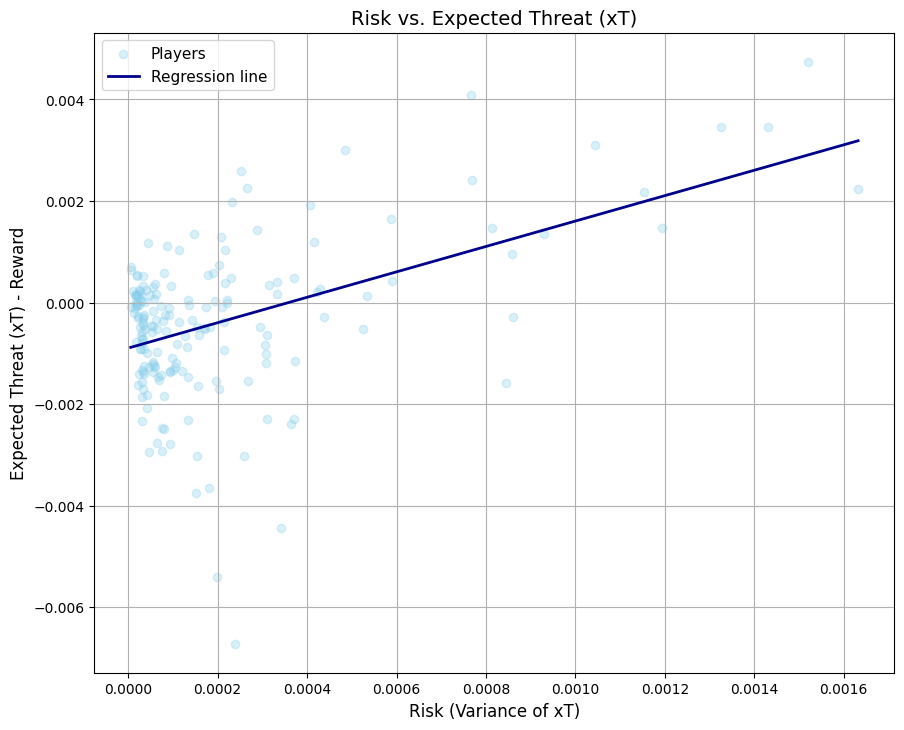

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats

# Prepare data
X = player_stats["var_xT"].values  # Variance of xT (risk)
y = player_stats["avg_xT"].values  # Average xT (reward)

# Fit regression model
model = LinearRegression().fit(X.reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X.reshape(-1, 1), y)

# Compute p-value using scipy's linregress
slope_, intercept_, r_value, p_value, std_err = stats.linregress(X, y)

# Plot
plt.figure(figsize=(10, 8))

plt.scatter(X, y, alpha=0.3, label="Players", color="skyblue")

# Regression line
x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_vals = model.predict(x_vals)
plt.plot(x_vals, y_vals, color="darkblue", linewidth=2, label="Regression line")

# Print regression details
print("R² value:", r_squared)
print("P-value:", p_value)
print(f"Slope (beta): {slope:.6f}")
print(f"Intercept (alpha): {intercept:.6f}")

# Labels and legend with smaller font sizes
plt.xlabel("Risk (Variance of xT)", fontsize=12)
plt.ylabel("Expected Threat (xT) - Reward", fontsize=12)
plt.title("Risk vs. Expected Threat (xT)", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=11)
plt.grid(True)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.show()


In [ ]:
# Calculate alpha for each player
player_stats["alpha"] = player_stats["avg_xT"] - (slope * player_stats["var_xT"] + intercept)


In [ ]:
# Sort by alpha in descending order
sorted_player_stats = player_stats.sort_values(by='alpha', ascending=True)

import pandas as pd
# Display the players with their alpha values, sorted by alpha
print(sorted_player_stats[['player_name', 'alpha', 'num_passes', 'total_xT', 'var_xT', 'avg_xT']].head(25))

                player_name    alpha  num_passes  total_xT  var_xT   avg_xT
103       Marcus Ingvartsen -0.00642          57  -0.38275 0.00024 -0.00671
5            Alexander Lind -0.00501          57  -0.30838 0.00020 -0.00541
51             Gue-Sung Cho -0.00440          63  -0.27972 0.00034 -0.00444
106           Marius Elvius -0.00323          59  -0.22080 0.00015 -0.00374
25          Callum McCowatt -0.00322         104  -0.38061 0.00018 -0.00366
176           Tonni Adamsen -0.00280         103  -0.16229 0.00085 -0.00158
172            Tobias Storm -0.00277          86  -0.25940 0.00026 -0.00302
129           Oliver Antman -0.00251          54  -0.16328 0.00015 -0.00302
137          Orri Óskarsson -0.00241          58  -0.13891 0.00036 -0.00239
20          Benjamin Nygren -0.00232          75  -0.17168 0.00037 -0.00229
178         Viktor Claesson -0.00221          96  -0.28016 0.00008 -0.00292
36           Denis Kolinger -0.00217          64  -0.18871 0.00005 -0.00295
14          

###xT Data

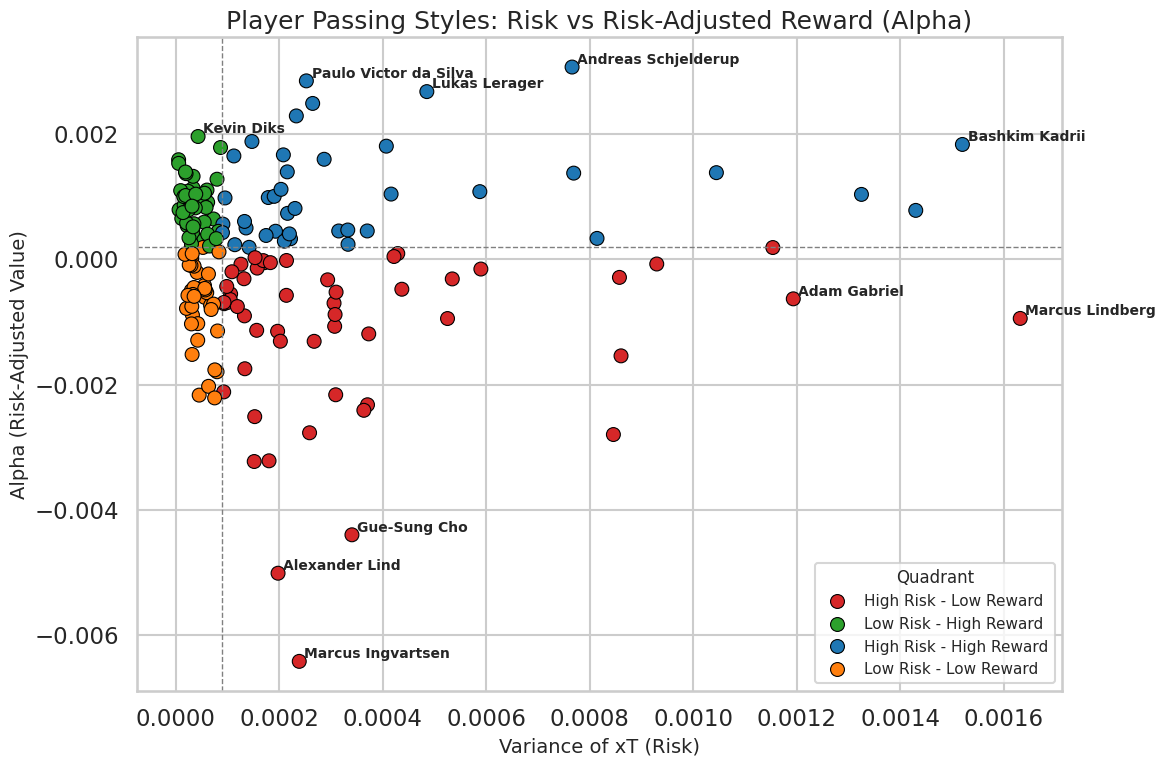

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up plot aesthetics
sns.set(style="whitegrid", context="talk")

# Calculate medians for quadrant splitting
median_std = player_stats["var_xT"].median()
median_alpha = player_stats["alpha"].median()

# Define color-coded quadrants
def get_quadrant(row):
    if row["var_xT"] >= median_std and row["alpha"] >= median_alpha:
        return "High Risk - High Reward"
    elif row["var_xT"] < median_std and row["alpha"] >= median_alpha:
        return "Low Risk - High Reward"
    elif row["var_xT"] < median_std and row["alpha"] < median_alpha:
        return "Low Risk - Low Reward"
    else:
        return "High Risk - Low Reward"

player_stats["quadrant"] = player_stats.apply(get_quadrant, axis=1)

# Color palette
palette = {
    "High Risk - High Reward": "#1f77b4",
    "Low Risk - High Reward": "#2ca02c",
    "Low Risk - Low Reward": "#ff7f0e",
    "High Risk - Low Reward": "#d62728"
}

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=player_stats,
    x="var_xT",
    y="alpha",
    hue="quadrant",
    palette=palette,
    s=100,
    edgecolor="black"
)

# Add quadrant lines
plt.axhline(median_alpha, color="gray", linestyle="--", linewidth=1)
plt.axvline(median_std, color="gray", linestyle="--", linewidth=1)

# Label standout players
highlighted_players = [
    "Andreas Schjelderup", "Paulo Victor da Silva", "Lukas Lerager",
    "Marcus Ingvartsen", "Alexander Lind", "Adam Gabriel", "Bashkim Kadrii", "Kevin Diks", "Gue-Sung Cho", "Marcus Lindberg"
]
for _, row in player_stats[player_stats["player_name"].isin(highlighted_players)].iterrows():
    plt.text(row["var_xT"] + 0.00001, row["alpha"] + 0.00005,
             row["player_name"], fontsize=10, weight='bold')

# Labels and title
plt.title("Player Passing Styles: Risk vs Risk-Adjusted Reward (Alpha)", fontsize=18)
plt.xlabel("Variance of xT (Risk)", fontsize=14)
plt.ylabel("Alpha (Risk-Adjusted Value)", fontsize=14)
plt.legend(title="Quadrant", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()


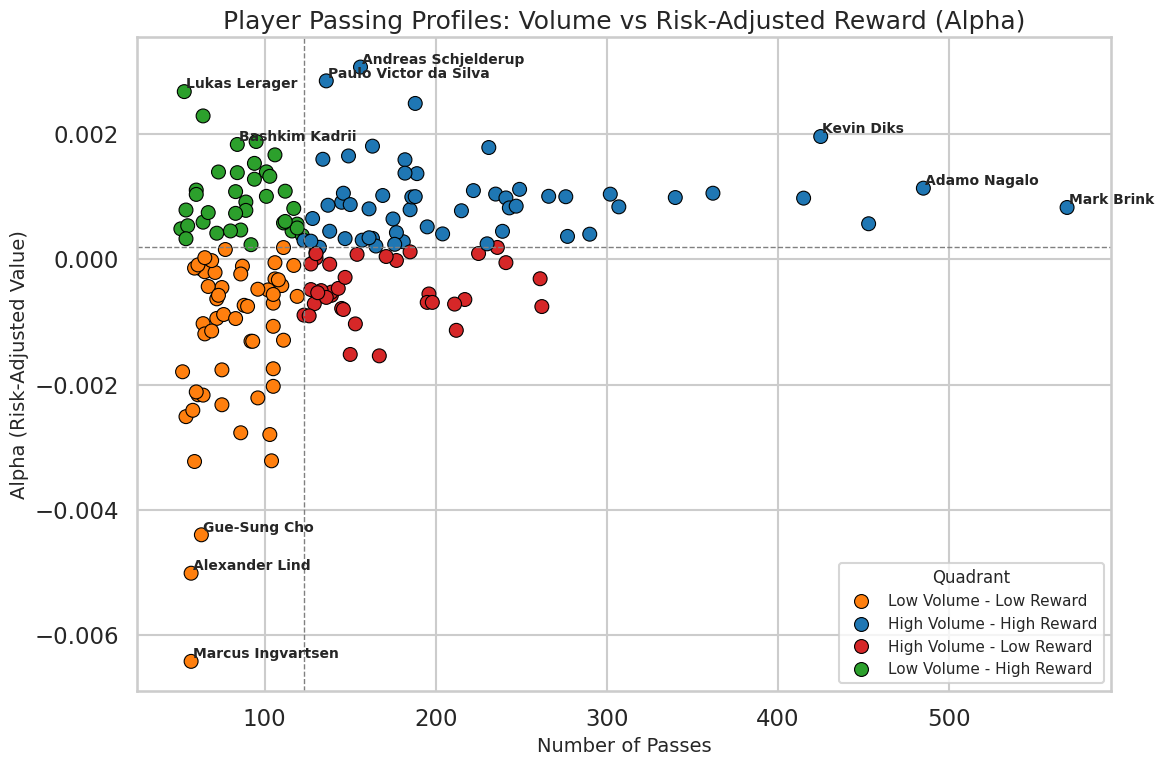

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up plot aesthetics
sns.set(style="whitegrid", context="talk")

# Calculate medians for quadrant splitting
median_passes = player_stats["num_passes"].median()
median_alpha = player_stats["alpha"].median()

# Define quadrants based on volume (x) and value (y)
def get_quadrant(row):
    if row["num_passes"] >= median_passes and row["alpha"] >= median_alpha:
        return "High Volume - High Reward"
    elif row["num_passes"] < median_passes and row["alpha"] >= median_alpha:
        return "Low Volume - High Reward"
    elif row["num_passes"] < median_passes and row["alpha"] < median_alpha:
        return "Low Volume - Low Reward"
    else:
        return "High Volume - Low Reward"

player_stats["quadrant"] = player_stats.apply(get_quadrant, axis=1)

# Color palette
palette = {
    "High Volume - High Reward": "#1f77b4",
    "Low Volume - High Reward": "#2ca02c",
    "Low Volume - Low Reward": "#ff7f0e",
    "High Volume - Low Reward": "#d62728"
}

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=player_stats,
    x="num_passes",
    y="alpha",
    hue="quadrant",
    palette=palette,
    s=100,
    edgecolor="black"
)

# Add quadrant lines
plt.axhline(median_alpha, color="gray", linestyle="--", linewidth=1)
plt.axvline(median_passes, color="gray", linestyle="--", linewidth=1)

# Highlight specific players
highlighted_players = [
    "Andreas Schjelderup", "Paulo Victor da Silva", "Lukas Lerager",
    "Marcus Ingvartsen", "Alexander Lind", "Adamo Nagalo", "Bashkim Kadrii",
    "Kevin Diks", "Gue-Sung Cho", "Mark Brink"
]
for _, row in player_stats[player_stats["player_name"].isin(highlighted_players)].iterrows():
    plt.text(row["num_passes"] + 1, row["alpha"] + 0.00005,
             row["player_name"], fontsize=10, weight='bold')

# Labels and title
plt.title("Player Passing Profiles: Volume vs Risk-Adjusted Reward (Alpha)", fontsize=18)
plt.xlabel("Number of Passes", fontsize=14)
plt.ylabel("Alpha (Risk-Adjusted Value)", fontsize=14)
plt.legend(title="Quadrant", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Get each player's most frequent starting position
player_positions = (
    ready_df.groupby('player_name')['starting_position']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# Merge starting position into player_stats
player_stats_with_position = player_stats.merge(
    player_positions,
    on='player_name',
    how='left'
)

# Calculate average alpha by starting position and count players for each position
avg_alpha_by_position = (
    player_stats_with_position.groupby('starting_position').agg(
        avg_alpha=('alpha', 'mean'),
        num_players=('player_name', 'nunique')
    )
    .reset_index()
    .sort_values(by='avg_alpha', ascending=False)
)

print(avg_alpha_by_position)



  starting_position  avg_alpha  num_players
0          Defender    0.00040           72
2        Midfielder    0.00007           66
1        Goalkeeper   -0.00028           14
3           Striker   -0.00089           31
4        Substitute   -0.00100            2


###Team level

In [ ]:
# Step 1: Count passes per player
passes_per_player = (
    ready_df.groupby('player_name')
    .size()
    .reset_index(name='player_num_passes')
)

# Step 2: Total passes per team
passes_per_team = (
    ready_df.groupby('team_name')
    .size()
    .reset_index(name='team_total_passes')
)

# Step 3: Get player-to-team mapping (most frequent team)
player_team_map = (
    ready_df.groupby('player_name')['team_name']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# Step 4: Merge everything into player_stats
player_stats_extended = (
    player_stats
    .merge(passes_per_player, on='player_name', how='left')
    .merge(player_team_map, on='player_name', how='left')
    .merge(passes_per_team, on='team_name', how='left')
)

# Step 5: Compute weight and weighted alpha
player_stats_extended['player_weight'] = (
    player_stats_extended['player_num_passes'] / player_stats_extended['team_total_passes']
)

player_stats_extended['weighted_alpha'] = (
    player_stats_extended['alpha'] * player_stats_extended['player_weight']
)

# Step 6: Compute weighted average alpha per team
weighted_alpha_per_team = (
    player_stats_extended.groupby('team_name')
    .agg(
        weighted_avg_alpha=('weighted_alpha', 'sum'),
        num_players=('player_name', 'nunique')
    )
    .reset_index()
    .sort_values(by='weighted_avg_alpha', ascending=False)
)

print(weighted_alpha_per_team)


          team_name  weighted_avg_alpha  num_players
1        Brøndby IF             0.00088           15
2      FC København             0.00064           18
4   FC Nordsjælland             0.00038           16
8        Randers FC             0.00029           12
3    FC Midtjylland             0.00024           16
11        Viborg FF             0.00019           17
9      Silkeborg IF             0.00012           18
0        AGF Aarhus             0.00011           16
5       Hvidovre IF            -0.00000           16
7   Odense Boldklub            -0.00000           14
6         Lyngby BK            -0.00030           16
10         Vejle BK            -0.00034           11


#Gøgl

In [ ]:
import pandas as pd

# Create a standings DataFrame manually
standings_df = pd.DataFrame({
    'team_name': [
        'FC Midtjylland', 'Brøndby IF', 'FC København', 'FC Nordsjælland', 'AGF Aarhus', 'Silkeborg IF',
        'Randers FC', 'Viborg FF', 'Vejle BK', 'Lyngby BK', 'Odense Boldklub', 'Hvidovre IF'
    ],
    'position': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'Points': [63, 62, 59, 58, 44, 36, 41, 40, 36, 36, 32, 20]
})


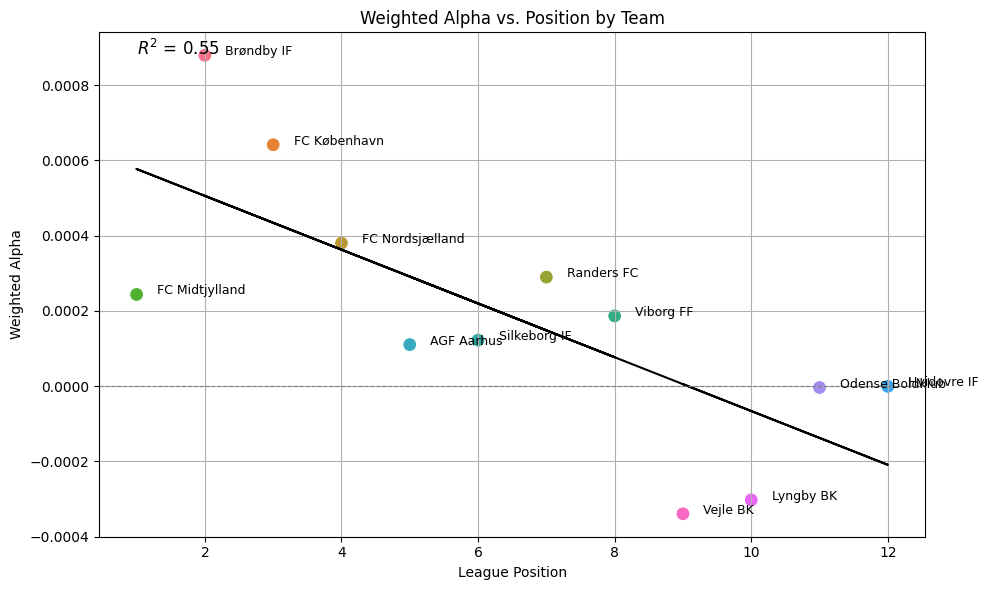

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Merge with standings data
alpha_vs_points = weighted_alpha_per_team.merge(
    standings_df,
    on='team_name',
    how='inner'
)

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(
    alpha_vs_points['position'],
    alpha_vs_points['weighted_avg_alpha']
)

# Create predicted y values for the regression line
regression_line = slope * alpha_vs_points['position'] + intercept

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=alpha_vs_points, x='position', y='weighted_avg_alpha', hue='team_name', s=100)

# Add regression line
plt.plot(alpha_vs_points['position'], regression_line, color='black', linestyle='-')

# Add R² value as text on the plot
plt.text(
    x=alpha_vs_points['position'].min(),
    y=alpha_vs_points['weighted_avg_alpha'].max(),
    s=f'$R^2$ = {r_value**2:.2f}',
    fontsize=12,
    color='black'
)

# Add team labels to each point
for _, row in alpha_vs_points.iterrows():
    plt.text(row['position'] + 0.3, row['weighted_avg_alpha'], row['team_name'], fontsize=9)

# Plot formatting
plt.title('Weighted Alpha vs. Position by Team')
plt.xlabel('League Position')
plt.ylabel('Weighted Alpha')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.tight_layout()
plt.legend().remove()
plt.show()


In [ ]:
x=player_stats_with_position[player_stats_with_position["player_name"]=="Paulo Victor da Silva"]
print(x)

               player_name  Expected_return  total_xT  num_passes  avg_xT  avg_Expected_return  var_xT   alpha                   quadrant starting_position
142  Paulo Victor da Silva          0.06802   0.35167         136 0.00259              0.00050 0.00025 0.00285  High Volume - High Reward          Defender


In [ ]:
# Step 1: Merge position info into a new copy of player_stats_extended
player_stats_extended1 = player_stats_extended.merge(
    player_positions,
    on='player_name',
    how='left'
)

# Step 2: Merge in average alpha per position
player_stats_extended1 = player_stats_extended1.merge(
    avg_alpha_by_position[['starting_position', 'avg_alpha']],
    on='starting_position',
    how='left'
).rename(columns={'avg_alpha': 'avg_alpha_position'})

# Step 3: Merge in team weighted average alpha (renamed to avg_alpha_team)
player_stats_extended1 = player_stats_extended1.merge(
    weighted_alpha_per_team[['team_name', 'weighted_avg_alpha']].rename(
        columns={'weighted_avg_alpha': 'avg_alpha_team'}
    ),
    on='team_name',
    how='left'
)

# Step 4: Subtract both effects to calculate adjusted alpha
player_stats_extended1['adjusted_alpha'] = (
    player_stats_extended1['alpha']
    - player_stats_extended1['avg_alpha_position']
    - player_stats_extended1['avg_alpha_team']
)

# Step 5 (Optional): display or sort
cols_to_show = [
    'player_name', 'team_name', 'starting_position', 'player_num_passes', 'avg_xT',
    'alpha', 'avg_alpha_position', 'avg_alpha_team', 'adjusted_alpha'
]


In [ ]:
print(player_stats_extended1[cols_to_show].sort_values(by='adjusted_alpha', ascending=False))

               player_name        team_name starting_position  player_num_passes   avg_xT    alpha  avg_alpha_position  avg_alpha_team  adjusted_alpha
10     Andreas Schjelderup  FC Nordsjælland           Striker                156  0.00409  0.00307            -0.00089         0.00038         0.00358
19          Bashkim Kadrii  Odense Boldklub           Striker                 84  0.00474  0.00183            -0.00089        -0.00000         0.00273
157      Stefán Thórdarson     Silkeborg IF        Midfielder                188  0.00226  0.00249             0.00007         0.00012         0.00230
81            Lirim Qamili      Hvidovre IF           Striker                 84  0.00310  0.00138            -0.00089        -0.00000         0.00227
142  Paulo Victor da Silva   FC Midtjylland          Defender                136  0.00259  0.00285             0.00040         0.00024         0.00221
..                     ...              ...               ...                ...      ...     

In [ ]:
# Sort by alpha in descending order
player_stats_extended1 = player_stats_extended1.sort_values(by='adjusted_alpha', ascending=False)

x= player_stats_extended1[['player_name', "starting_position", 'alpha', 'num_passes', "adjusted_alpha"]]

player_stats_extended1 = player_stats_extended1.sort_values(by='adjusted_alpha', ascending=True)

y = player_stats_extended1[['player_name', "starting_position", 'team_name', 'alpha', 'num_passes', "adjusted_alpha"]]

x.to_excel('/content/gdrive/MyDrive/adj_alpha_top.xlsx')
y.to_excel('/content/gdrive/MyDrive/adj_alpha_end.xlsx')